## OntoNotes v5 - Dataset


NOTE: 
Turns our CDLM model is huge and its 4096-token limit (which eats up compute and takes forever to fine-tune), we’re switching to bert-base-uncased. It’s lightweight, maxes out at 512 tokens, and lets us iterate way faster.

Since 512 tokens isn’t enough to handle cross-document coreference, we’ll just focus on within-document coreference resolution.

The dataset we’ll use is OntoNotes v5 small and already available on Hugging Face. Each document contains multiple sentences with annotated coreference chains, which is perfect for our purpose.

-----------------

We can define a "document quality" score maybe something like: (# coref chains / # tokens) or (# mentions / # tokens). Let's say we normalize that between 0 and 1. We'll inject that score into the input as a special token, like this:  <span style="color:red">< s > 0.3 < /s > < m > John < /m > went to the store. < m > He < /m > bought milk.</span>
To do this, we can add < s > and < /s > to the tokenizer vocab (see example below: tokenizer.add_tokens()).

-----------------

Then we train two versions of the model:
* Baseline - BERT classifier without the score
* Score-aware - BERT classifier with the score


---------------------

At test time, we compare F1 scores from both models and analyze -> Does adding document quality help the model perform better? 
Then, we can plot F1 score vs doc quality using simple scatter plot. i.e. doc_score = [doc1_score, doc2_score,....]; F1_score = [doc1_f1, doc2_f2, ....]


In [ ]:
import torch
import random
import numpy as np
import tqdm
import time

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.utils.data import Dataset, DataLoader
from peft import get_peft_model, LoraConfig, TaskType
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
MODEL_NAME = "bert-base-uncased" #"biu-nlp/cdlm"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Add special tokens and resize
tokenizer.add_tokens(['<m>', '</m>'], special_tokens=True)                                              # NOTE: add <s>, </s> for doc quality


# If weighting document quality
score = True
if score:
    score_tokens = [
    "<S1=low>", "<S1=mid>", "<S1=high>", "<S1=veryhigh>",
    "<S2=low>", "<S2=mid>", "<S2=high>", "<S2=veryhigh>",
    "<S3=low>", "<S3=mid>", "<S3=high>", "<S3=veryhigh>"]

    tokenizer.add_tokens(score_tokens, special_tokens=True)

#tokenizer.add_tokens(['<g>'], special_tokens=True)   # Only needed when using global attention in Longformer models.

# Load model and resize accordingly
model = AutoModel.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))


# Inject LoRA into the encoder
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=['query', 'value'],   # attention modules
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION           # LoRA will no longer expect a labels argument internally
)

model = get_peft_model(model, config).to(DEVICE)
model.print_trainable_parameters()

In [ ]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.uniform_(m.bias)

classifier = torch.nn.Sequential(
    torch.nn.Linear(model.config.hidden_size * 4, model.config.hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(model.config.hidden_size, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)
).to(DEVICE)

classifier.apply(init_weights)

loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(list(model.parameters()) + list(classifier.parameters()), lr = 2e-5)

### Load Dataset

In [ ]:
ds = load_dataset("conll2012_ontonotesv5", "english_v4")

What __build_index(self): produces?

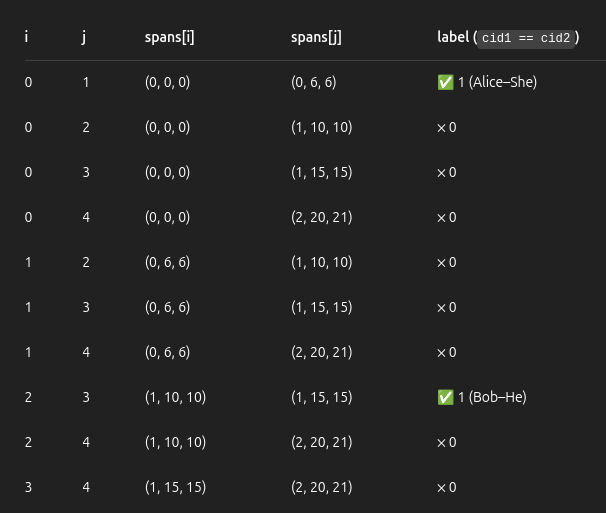

In [ ]:
"""# Full Dataset Class
class MentionPairDataset(Dataset):
    def __init__(self, hf_dataset_split, tokenizer, score = False):
        self.doc_list = hf_dataset_split
        self.index = self.__build_index()
        self.tokenizer = tokenizer
        self.score = score # Bool

    def __build_index(self):
        # Flat list of (doc_idx, m1_idx, m2_idx) for pair access
        index = []

        for doc_idx, doc in enumerate(self.doc_list):
            _, spans = self.flatten_document(doc)

            for i in range(len(spans)):
                for j in range(i+1, len(spans)):
                    index.append((doc_idx, i, j))

        '''
           See attached figure above. 
        '''
        print(f"# of Mention Pairs (Version 1): {len(index)}")

        return index

    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx):
        doc_idx, i, j = self.index[idx]
        doc = self.doc_list[doc_idx]

        words, spans = self.flatten_document(doc)

        print (f'Length of spans: {len(spans)}')

        #print (words)
        #print (spans)
        
        (cid1, s1, e1) = spans[i]
        (cid2, s2, e2) = spans[j]
        label = torch.tensor(float(cid1 == cid2))
        
        text = self.create_truncated_text(words, (s1, e1), (s2, e2), self.tokenizer, score = self.score)

        return text, label


    def create_text(self, words, m1_span, m2_span):
        '''
            OBSOLETE NOTE: use create_truncated_text()
        '''
        w = words.copy()
        m1_start, m1_end = m1_span
        m2_start, m2_end = m2_span

        if m2_start < m1_start:
            (m1_start, m1_end), (m2_start, m2_end) = (m2_start, m2_end), (m1_start, m1_end)

        # Insert tokens in reverse order so indices stay valid
        w.insert(m2_end + 1, "</m>")
        w.insert(m2_start, "<m>")
        w.insert(m1_end + 1, "</m>")
        w.insert(m1_start, "<m>")

        text = " ".join(w)

        return text
    
    def create_truncated_text(self, words, m1_span, m2_span, tokenizer, max_length=512, context_window=122, score = False):
        '''
        Truncate around mentions and ensure the final tokenized output includes both mentions
        and fits within the model's max_length.
        '''

        if score == False:
            extra_token_num = 2 # [CLS] and [SEP]
        else:
            extra_token_num = 3 # [CLS], [SEP] and [S] = doc_score

        m1_start, m1_end = m1_span
        m2_start, m2_end = m2_span

        if m2_start < m1_start:
            (m1_start, m1_end), (m2_start, m2_end) = (m2_start, m2_end), (m1_start, m1_end)

        left_context_start = max(0, m1_start - context_window)
        left_context = words[left_context_start:m1_start]

        mention1 = words[m1_start:m1_end + 1]
        between_mentions = words[m1_end + 1:m2_start]
        mention2 = words[m2_start:m2_end + 1]

        right_context_end = min(len(words), m2_end + 1 + context_window)
        right_context = words[m2_end + 1:right_context_end]

        def get_tokens(seq):
            return tokenizer(seq, is_split_into_words=True, add_special_tokens=False)["input_ids"]

        while True:
            # Compose candidate
            seq = (
                left_context + ["<m>"] + mention1 + ["</m>"]
                + between_mentions + ["<m>"] + mention2 + ["</m>"]
                + right_context
            )
            token_ids = get_tokens(seq)

            # Add 2 for [CLS] and [SEP]
            if len(token_ids) + extra_token_num <= max_length:
                break

            # Prune in this order: between_mentions → left_context → right_context
            if len(between_mentions) > 0:
                between_mentions = between_mentions[1:-1]
            elif len(left_context) > 0:
                left_context = left_context[1:]
            elif len(right_context) > 0:
                right_context = right_context[:-1]
            else:
                break

        # Reconstruct string for final encoding
        final = (
            left_context + ["<m>"] + mention1 + ["</m>"]
            + between_mentions + ["<m>"] + mention2 + ["</m>"]
            + right_context
        )
        return " ".join(final)

    
    def flatten_document(self, document):
        words, spans = [],[]

        for sent in document['sentences']:
            offset = len(words)
            words.extend(sent['words'])

            for span in sent['coref_spans']:
                cluster_id, start, end = span
                spans.append((cluster_id, offset + start, offset + end))  # inclusive span

        # Example:
        '''words = [
                "Alice", "went", "to", "the", "market", ".",           
                "She", "bought", "apples", ".",                      
                "Bob", "was", "there", "too", ".",                    
                "He", "greeted", "her", ".",                           
                "The", "company", "was", "not", "far", "away", "."]

            spans = [
                    (0, 0, 0),  # "Alice"
                    (0, 6, 6),  # "She"          → same cluster as "Alice"
                    (1, 10, 10),# "Bob"
                    (1, 15, 15),# "He"           → same cluster as "Bob"
                    (2, 20, 21) # "The company"
                ]'''


        return words, spans    # full text, all coref spans


    def generate_mention_pairs(self, spans):
        '''
        Returns list of (span1, span2, label)
        '''
        mention_pairs = []
        for i in range(len(spans)):
            for j in range(i+1, len(spans)):
                id1, start1, end1 = spans[i]
                id2, start2, end2 = spans[j]
                label = int(id1 == id2)
                mention_pairs.append(((start1, end1), (start2, end2), label))
        
        # i.e. (mention1, mention2, label == 0 or 1)
        return mention_pairs"""

In [ ]:
len_words = []
for i in range(len(ds['train'])):
    doc = ds['train'][i]
    word_count = 0
    for sent in doc['sentences']:
        word_count += len(sent['words'])
    
    len_words.append(word_count)

In [ ]:
np.mean(len_words)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(len_words, bins=1000)

plt.title("Distribution of Document Lengths (OntoNotes)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()


In [ ]:
score1_list = []
score2_list = []
score3_list = []

for doc in ds['train']:
    s1, s2, s3 = compute_doc_score(doc)
    score1_list.append(s1)
    score2_list.append(s2)
    score3_list.append(s3)

bins_s1 = np.quantile(score1_list, [0.25, 0.5, 0.75])
bins_s2 = np.quantile(score2_list, [0.25, 0.5, 0.75])
bins_s3 = np.quantile(score3_list, [0.25, 0.5, 0.75])

In [ ]:
tokenizer.get_added_vocab

In [ ]:
from collections import defaultdict
import itertools

def bucketize(score, prefix = "S", bins=[0.25, 0.5, 0.75]):
    if score < bins[0]:
        return f"<{prefix}=low>"
    elif score < bins[1]:
        return f"<{prefix}=mid>"
    elif score < bins[2]:
        return f"<{prefix}=high>"
    else:
        return f"<{prefix}=veryhigh>"

def compute_doc_score(doc):
    '''
        Computes 3 document-level (not cross-document level) heuristic scores:
        - score1: mention density
        - score2: cluster richness
        - score3: length normalization

        Returns:
            List of raw [score1, score2, score3], each \in [0.0, 1.0] 
    '''

    total_tokens = sum(len(sent['words']) for sent in doc['sentences'])
    total_mentions = sum(len(sent['coref_spans']) for sent in doc['sentences'])

    # Collect all unique cluster IDs
    cluster_ids = set()
    for sent in doc['sentences']:
        for cid, _, _ in sent['coref_spans']:
            cluster_ids.add(cid)
    
    total_clusters = len(cluster_ids)

    score1 = total_mentions / (total_tokens + 1e-6)         # mention density
    score2 = total_clusters / (total_mentions + 1e-6)       # cluster richness
    score3 = min(total_tokens / 669.75, 1.0)                 # doc length normalization: mean word count per doc in training set is 669.75

    score1 = min(score1, 1.0)
    score2 = min(score2, 1.0)

    return [score1, score2, score3]




# Full Dataset Class - Version 2.0
class MentionPairDataset(Dataset):
    def __init__(self, hf_dataset_split, tokenizer, score = False):
        '''Initialize Entire data s.t. 
        during training, fetching data is just a simple lookup'''

        self.tokenizer = tokenizer
        self.score = score # Bool
        self.max_length = self.tokenizer.model_max_length    # 512 for BERT-base-uncased
        self.context_window = 122                            # window around each mention

        self.examples = []

        if score:
            print (f'Creating Dynamic Bucket Bins...')
            self.bins_s1, self.bins_s2, self.bins_s3 = self.create_bucket_bins(hf_dataset_split)

        for doc in tqdm.tqdm(hf_dataset_split, desc = 'Preprocessing dataset'):
            words, spans = self.flatten_document(doc)   # spans: [(cluster_id, start, end)]

            #print (f'Length of spans: {len(spans)}')   # NOTE: This is the number of mentions, not the number of clusters.
            #print (spans)

            '''for i in range(len(spans)):
                for j in range(i+1, len(spans)):
                    (cid1, s1, e1) = spans[i]
                    (cid2, s2, e2) = spans[j]
                    label = torch.tensor(float(cid1 == cid2))

                    # NOTE: This is taking TOO LONG !!!! O(n^2) calls. SLOOOWWW
                    text = self.create_truncated_text(words, (s1, e1), (s2, e2))   
                    self.examples.append((text, label))'''
            
            positive_pairs = []
            negative_pairs = []

            cluster_map = defaultdict(list)

            # Group mentions by cluster ID
            for cid, s, e in spans:
                cluster_map[cid].append((s,e))

            # Populate positive_pairs
            for mentions in cluster_map.values():
                if len(mentions) >= 2:
                    # sample up to max_pairs_per_cluster from combinations
                    all_pairs = list(itertools.combinations(mentions, 2))
                    sampled = random.sample(all_pairs, min(len(all_pairs), 3))    # Pick 3 or fewer postitve pairs per cluster.
                    for m1, m2 in sampled:
                        positive_pairs.append((m1, m2, 1.0))

            # Populate negative_pairs
            for i in range(len(spans)):
                for j in range(i+1, len(spans)):
                    (cid1, s1, e1) = spans[i]
                    (cid2, s2, e2) = spans[j]

                    if cid1 != cid2:
                        negative_pairs.append(((s1, e1), (s2, e2), 0.0))
                    
            #print (f'[INFO] {len(positive_pairs)} positive and {len(negative_pairs)} negative pairs found')

            # Downsample negatives
            sampled_negatives = random.sample(negative_pairs, min(len(positive_pairs), len(negative_pairs)))
            
            # comobine and shuffle
            final_pairs = positive_pairs + sampled_negatives
            random.shuffle(final_pairs)

            #print ('Length of final_pairs: ', len(final_pairs))
            
            #count = 1
            for m1, m2, label_val in final_pairs:
                if not self.score:
                    text = self.create_truncated_text(words, m1, m2)
                else:
                    doc_scores = compute_doc_score(doc)
                    text = self.create_truncated_text(words, m1, m2, doc_scores)
                #print (f'{count}/{len(final_pairs)} pairs processed')
                #count += 1
                label = torch.tensor(label_val)
                self.examples.append((text, label))
                
                print (text)
            break


    def __len__(self):
        return len(self.examples)
    

    def __getitem__(self, idx):
        return self.examples[idx]

    def create_bucket_bins(self, dataset):
        '''
            Dynamic binning based on actual dataset distribution
        '''

        score1_list = []
        score2_list = []
        score3_list = []

        for doc in dataset:
            s1, s2, s3 = compute_doc_score(doc)
            score1_list.append(s1)
            score2_list.append(s2)
            score3_list.append(s3)

        bins_s1 = np.quantile(score1_list, [0.25, 0.5, 0.75])
        bins_s2 = np.quantile(score2_list, [0.25, 0.5, 0.75])
        bins_s3 = np.quantile(score3_list, [0.25, 0.5, 0.75])

        return bins_s1, bins_s2, bins_s3

    def flatten_document(self, document):
        words, spans = [],[]

        for sent in document['sentences']:
            offset = len(words)
            words.extend(sent['words'])

            for span in sent['coref_spans']:
                cluster_id, start, end = span
                spans.append((cluster_id, offset + start, offset + end))  # inclusive span

        return words, spans    # full text, all coref spans
    
    
    def create_truncated_text(self, words, m1_span, m2_span, doc_scores = None):
        """
        Truncate around mentions and ensure the final tokenized output includes both mentions
        and fits within the model's max_length.
        """

        if self.score == False:
            extra_token_num = 2 # [CLS] and [SEP]
        else:
            extra_token_num = 5 # [CLS], [SEP] and [S1] [S2] [S3] = doc_score

        m1_start, m1_end = m1_span
        m2_start, m2_end = m2_span

        if m2_start < m1_start:
            (m1_start, m1_end), (m2_start, m2_end) = (m2_start, m2_end), (m1_start, m1_end)

        left_context_start = max(0, m1_start - self.context_window)
        left_context = words[left_context_start:m1_start]

        mention1 = words[m1_start:m1_end + 1]
        between_mentions = words[m1_end + 1:m2_start]
        mention2 = words[m2_start:m2_end + 1]

        right_context_end = min(len(words), m2_end + 1 + self.context_window)
        right_context = words[m2_end + 1:right_context_end]

        # Pre-tokenize all components
        get_tokens = lambda seq: self.tokenizer(seq, is_split_into_words=True, add_special_tokens=False)["input_ids"]

        left_tokens = get_tokens(left_context)
        right_tokens = get_tokens(right_context)
        mention1_tokens = get_tokens(mention1)
        mention2_tokens = get_tokens(mention2)
        between_tokens = get_tokens(between_mentions)

        # Add 4 for <m> and </m> tokens, which were added to tokenizer
        m_token_id = self.tokenizer.convert_tokens_to_ids("<m>")
        m_end_token_id = self.tokenizer.convert_tokens_to_ids("</m>")

        # Pre-compute mention-wrapped sequences
        mention1_tokens = [m_token_id] + mention1_tokens + [m_end_token_id]
        mention2_tokens = [m_token_id] + mention2_tokens + [m_end_token_id]

        while True:
            total_len = (
                len(left_tokens) + len(mention1_tokens) + 
                len(between_tokens) + len(mention2_tokens) +
                len(right_tokens) + extra_token_num + 4  # 4 for two <m> and two </m>
            )
            if total_len <= self.max_length:
                break

            # Trim between_mentions -> left context -> right context (token level now)
            if len(between_tokens) > 2:
                between_tokens = between_tokens[1:-1]
            elif len(left_tokens) > 0:
                left_tokens = left_tokens[1:]
            elif len(right_tokens) > 0:
                right_tokens = right_tokens[:-1]
            else:
                break

        #final_token_ids = (
        #    left_tokens + mention1_tokens + between_tokens + mention2_tokens + right_tokens
        #)

        # Decode back to text - 
        #final_text = self.tokenizer.decode(final_token_ids, skip_special_tokens = True)
        #print (final_text)
        mention1_text = self.tokenizer.convert_ids_to_tokens(mention1_tokens[1:-1])
        mention2_text = self.tokenizer.convert_ids_to_tokens(mention2_tokens[1:-1])

        if not self.score:
            final_tokens = (
                self.tokenizer.convert_ids_to_tokens(left_tokens) +
                ["<m>"] + mention1_text + ["</m>"] +
                self.tokenizer.convert_ids_to_tokens(between_tokens) +
                ["<m>"] + mention2_text + ["</m>"] +
                self.tokenizer.convert_ids_to_tokens(right_tokens)
            )
        else:
            assert doc_scores is not None, "doc_score must be provided when self.score = True"
            score1, score2, score3 = doc_scores  # raw_scores
            s1_token = bucketize(score1, prefix = "S1", bins = self.bins_s1)
            s2_token = bucketize(score2, prefix = "S2", bins = self.bins_s2)
            s3_token = bucketize(score3, prefix = "S3", bins = self.bins_s3)


            final_tokens = (
                [s1_token] + [s2_token] + [s3_token] + 
                self.tokenizer.convert_ids_to_tokens(left_tokens) +
                ["<m>"] + mention1_text + ["</m>"] +
                self.tokenizer.convert_ids_to_tokens(between_tokens) +
                ["<m>"] + mention2_text + ["</m>"] +
                self.tokenizer.convert_ids_to_tokens(right_tokens)
            )


        final_text = " ".join(final_tokens)
        return final_text

        '''def get_tokens(seq):
            return self.tokenizer(seq, is_split_into_words=True, add_special_tokens=False)["input_ids"]

        while True:
            # Compose candidate
            seq = (
                left_context + ["<m>"] + mention1 + ["</m>"]
                + between_mentions + ["<m>"] + mention2 + ["</m>"]
                + right_context
            )
            token_ids = get_tokens(seq)

            # Add 2 for [CLS] and [SEP]
            if len(token_ids) + extra_token_num <= self.max_length:
                break

            # Prune in this order: between_mentions → left_context → right_context
            if len(between_mentions) > 0:
                between_mentions = between_mentions[1:-1]
            elif len(left_context) > 0:
                left_context = left_context[1:]
            elif len(right_context) > 0:
                right_context = right_context[:-1]
            else:
                break

        # Reconstruct string for final encoding
        final = (
            left_context + ["<m>"] + mention1 + ["</m>"]
            + between_mentions + ["<m>"] + mention2 + ["</m>"]
            + right_context
        )
        return " ".join(final)'''

In [ ]:
# Get training dataset with (examples, labels)
train = MentionPairDataset(ds['train'], tokenizer=tokenizer, score=True)  # Gets truncated text centered around mention spans.

In [ ]:
# Save train set
torch.save(train.examples, "data/mention_pair_examples_train.pt")
#torch.save(train.examples, "mention_pair_examples_train_scored.pt")    # NOTE: run this if generating scored training set

In [ ]:
train = torch.load("mention_pair_examples_train.pt")
train

In [ ]:
train_loader = DataLoader(train, batch_size=1, num_workers = 0, shuffle = True, pin_memory=True)

In [ ]:
for i, (batch_x, batch_y) in enumerate(train_loader):
    token = tokenizer(batch_x, padding="max_length", max_length = 512, return_tensors="pt", truncation=True, add_special_tokens=True)
    ids =token['input_ids'][0]
    print (tokenizer.convert_ids_to_tokens(ids))
    break

In [ ]:
len(ids)

In [ ]:
tokenizer._convert_id_to_token[ids]

### Need to extract embeddings from the final layer of transformer

In [ ]:
def extract_mention_repr(input_ids, hidden_states, m_token_id, m_end_token_id):
    """
    Extract [CLS, mention1, mention2, mention1*mention2] representation from hidden states...similar to the paper.
    Returns a tensor of shape (batch_size, 4 * hidden_dim)
    """

    batch_size = input_ids.size(0)
    hidden_size = hidden_states.size(-1)
    reps = []

    for i in range(batch_size):
      ids = input_ids[i]          # (seq_len,)
      hs = hidden_states[i]       # (seq_len, hidden_dim)

      # Get CLS token (assume at index 0)
      cls_vec = hs[0]            # (hidden_dim of CLS token)

      # Find all <m> and </m> positions
      m_starts = (ids == m_token_id).nonzero(as_tuple=True)[0]
      m_ends = (ids == m_end_token_id).nonzero(as_tuple=True)[0]

      if len(m_starts) != 2 or len(m_ends) != 2:
        raise ValueError("Expected exactly two <m> and two </m> markers per example")
      
      # Mention 1
      start1 = m_starts[0].item() + 1
      end1 = m_ends[0].item()
      mention1_vec = hs[start1:end1].sum(dim=0)   # (hidden_dim,)

      # Mention 2
      start2 = m_starts[1].item() + 1
      end2 = m_ends[1].item()
      mention2_vec = hs[start2:end2].sum(dim=0)   # (hidden_dim,)

      # Elementwise product
      mention_product = mention1_vec * mention2_vec

      #print("Mention 1 span:", start1, "to", end1, "->", tokenizer.convert_ids_to_tokens(ids[start1:end1]))
      #print("Mention 2 span:", start2, "to", end2, "->", tokenizer.convert_ids_to_tokens(ids[start2:end2]))

      # Final representation 
      concat = torch.cat([cls_vec, mention1_vec, mention2_vec, mention_product], dim =-1) # (4 * hidden_dim,)
      reps.append(concat)
  
    return torch.stack(reps)  # (batch_size, 4 * hidden_dim)


### Main Training Loop - Run This

Something weird is going on in "for i, (batch_x, batch_y) in enumerate(train_loader)" below. Takes a long time to execute...need to look into it. However, the forward pass to the model shpuld be fast.

In [ ]:
batch_x = ["Hello my name is <m> Bipin Koirala </m> . Georgia Tech. <m> I </m> am an idiot",
           "Hello my name is <m> Bipin Koirala </m> . </s> </doc-s> <doc-s> <s> <m> He </m> am an idiot"]

batch_y = torch.tensor([1.0, 0.0])

tokens = tokenizer(batch_x, padding="max_length", max_length=512, return_tensors="pt", truncation=True, add_special_tokens=True)
tokens['input_ids']

In [ ]:
tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

In [ ]:
num_epochs = 5

m_id = tokenizer.convert_tokens_to_ids('<m>')
m_end_id = tokenizer.convert_tokens_to_ids('</m>')

for epoch in range(num_epochs):
    model.train()
    classifier.train()

    total_loss = 0.0
    all_preds = []
    all_labels = []


    start_data = time.time()
    for i, (batch_x, batch_y) in enumerate(train_loader):
        end_data = time.time()
        print (f'Batch {i+1}: Loaded in {end_data-start_data} sec')

        start_model = time.time()
        bert_tokens = tokenizer(
            batch_x,
            padding = "max_length",
            max_length = 512,
            return_tensors = "pt",
            truncation = True,
            add_special_tokens = True
        )

        #print ('Acquired batch_x, batch_y')
        #print (type(batch_x))
        
        input_ids = bert_tokens['input_ids'].to(DEVICE)
        attention_mask = bert_tokens['attention_mask'].to(DEVICE)
        batch_y = batch_y.to(DEVICE)

        if len(input_ids) > 512:
            print(f"[Warning] Input {i} too long: {len(input_ids)} tokens")

        try:
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            hidden_states = outputs['last_hidden_state']     #(batch_size, token_len, hidden_dim)
            reps = extract_mention_repr(input_ids, hidden_states, m_id, m_end_id)
        except ValueError as e:
            tqdm.tqdm.write(f"[Skipping example {i}] Reason: {e}")
            continue

        logits = classifier(reps)
        loss = loss_fn(logits.squeeze(-1), batch_y)
        
        loss.backward()

        #params = list(model.parameters()) + list(classifier.parameters())

        #torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        print (f'Total_loss: {total_loss}')

        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        labels = batch_y.detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

        end_model = time.time()

        #print (f'Model Training time for Batch {i+1}: {end_model - start_model} sec')
        print ('\n')
        start_data = time.time()


    # compute metrics at the end of each epoch
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Total Loss: {total_loss:.4f}")
    print(f"  Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}\n")

### Debug Below if needed....

In [ ]:
'''batch_x = [
    "My friend <m> Alice </m> went to the store. <m> She </m> bought apples.",
    "The car <m> Tesla </m> is fast. <m> Elon </m> drives it."
]

batch_y = torch.tensor([1.0, 0.0])  # First example: coref, second: not coref

m_id = tokenizer.convert_tokens_to_ids('<m>')
m_end_id = tokenizer.convert_tokens_to_ids('</m>')

bert_tokens = tokenizer(batch_x, padding = "max_length", max_length = 512, return_tensors = "pt", truncation = False, add_special_tokens = True)
input_ids = bert_tokens['input_ids'].to(DEVICE)
attention_mask = bert_tokens['attention_mask'].to(DEVICE)

outputs = model(input_ids = input_ids, attention_mask = attention_mask)
hidden_states = outputs['last_hidden_state']     #(batch_size, token_len, hidden_dim)

reps = extract_mention_repr(input_ids, hidden_states, m_id, m_end_id)

logits = classifier(reps)
loss = loss_fn(logits.squeeze(-1), batch_y)'''

In [ ]:
import torch
import random
import numpy as np
import tqdm
import time

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.utils.data import Dataset, DataLoader
from peft import get_peft_model, LoraConfig, TaskType
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from dataset import MentionPairDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
MODEL_NAME = "bert-base-uncased" #"biu-nlp/cdlm"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)


tokenizer = AutoTokenizer.from_pretrained("data/tokenizer_train_scored")
model = AutoModel.from_pretrained("bert-base-uncased")
model.resize_token_embeddings(len(tokenizer))

In [1]:
from dataset import MentionPairDataset

train = torch.load('data/mention_pairs_train_scored.pt')
train_loader = DataLoader(train, batch_size=1, num_workers = 0, shuffle = True, pin_memory=True)

ModuleNotFoundError: No module named 'dataset'

In [ ]:
import os

os.chdir('..')
import tqdm
import time
import torch
import random
import numpy as np

from datasets import load_dataset
from dataset import MentionPairDataset
from utility import *

from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.utils.data import Dataset, DataLoader

from peft import get_peft_model, LoraConfig, TaskType

from torch.nn import BCEWithLogitsLoss

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

score = True
# Load Tokenizer
if score:
    tokenizer = AutoTokenizer.from_pretrained("data/tokenizer_train_scored")
else:
    tokenizer = AutoTokenizer.from_pretrained("data/tokenizer_train")

# Load BERT and resize
model = AutoModel.from_pretrained("bert-base-uncased")
model.resize_token_embeddings(len(tokenizer))

# Inject LoRA into the encoder
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=['query', 'values'],
    lora_dropout=0.1,
    bias='none',
    task_type=TaskType.FEATURE_EXTRACTION
)


model = get_peft_model(model, config).to(DEVICE)
model.print_trainable_parameters()

# Classifier
if not score:
    classifier = torch.nn.Sequential(
        torch.nn.Linear(model.config.hidden_size * 4, model.config.hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(model.config.hidden_size, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 1)
    ).to(DEVICE)
else:
    classifier = torch.nn.Sequential(
        torch.nn.Linear(model.config.hidden_size * 8, model.config.hidden_size * 2),
        torch.nn.ReLU(),
        torch.nn.Linear(model.config.hidden_size * 2, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 1)
    ).to(DEVICE)


loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(list(model.parameters()) + list(classifier.parameters()), lr = 2e-5)


#train_data = torch.load('data/mention_pairs_train_scored.pt' if score else 'data/mention_pairs_train.pt')
val_data = torch.load('data/mention_pairs_validation_scored.pt' if score else 'data/mention_pairs_validation.pt')

train_loader = DataLoader(val_data, batch_size = 2, num_workers = 0, shuffle = True, pin_memory = True)
val_loader = DataLoader(val_data, batch_size = 2, num_workers = 0, shuffle = True, pin_memory = True)

/home/b53k/miniconda3/envs/base-proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainable params: 147,456 || all params: 109,640,448 || trainable%: 0.1345


/tmp/ipykernel_72525/3554512116.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_data = torch.load('data/mention_pairs_validation_scored.pt' if score else 'data/ment

In [2]:
def run_validation(model, classifier, dataloader, max_batches=10):
    model.eval()
    classifier.eval()

    all_preds = []
    all_labels = []

    m_id = tokenizer.convert_tokens_to_ids('<m>')
    m_end_id = tokenizer.convert_tokens_to_ids('</m>')

    val_subset = random.sample(list(dataloader), min(max_batches, len(dataloader)))

    with torch.no_grad():
        for batch_x, batch_y in val_subset:
            tokens = tokenizer(batch_x, padding="max_length", max_length=512, return_tensors="pt", truncation=True, add_special_tokens=True)
            input_ids = tokens['input_ids'].to(DEVICE)
            attention_mask = tokens['attention_mask'].to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            try:
                outputs = model(input_ids, attention_mask)
                hidden_states = outputs['last_hidden_state']
                reps = extract_mention_repr(input_ids, hidden_states, m_id, m_end_id, include_scores=score)
            except ValueError as e:
                continue

            logits = classifier(reps).squeeze(-1)
            preds = (torch.sigmoid(logits) > 0.5).int()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(batch_y.cpu().tolist())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    return precision, recall, f1, acc


In [ ]:
save_path = 'models/model_scored.pt' if score else 'model.pt'

m_id = tokenizer.convert_tokens_to_ids('<m>')
m_end_id = tokenizer.convert_tokens_to_ids('</m>')

Epochs = 5
best_val_f1 = 0
patience = 2
trigger_times = 0

val_check_batch = 100

for epoch in tqdm.trange(Epochs, desc="Training", unit="epoch"):
    with tqdm.tqdm(train_loader, desc=f'epoch {epoch+1}', unit='batch', total=len(train_loader), position=0, leave=True) as batch_iterator:
        model.train()
        classifier.train()

        total_loss = 0.0
        all_preds = []
        all_labels = []
        
        for i, (batch_x, batch_y) in enumerate(batch_iterator, start=1):
            tokens = tokenizer(batch_x, padding="max_length", max_length=512, return_tensors="pt", truncation=True, add_special_tokens=True)
            input_ids = tokens['input_ids'].to(DEVICE)
            attention_mask = tokens['attention_mask'].to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()   # Clear accumulated gradients

            try:
                outputs = model(input_ids, attention_mask)
                hidden_states = outputs['last_hidden_state']            # [batch_size, token_len, hidden_dim] : [4, 512, 768]
                reps = extract_mention_repr(input_ids, hidden_states, m_id, m_end_id, include_scores=score)
            except ValueError as e:
                tqdm.tqdm.write(f"[Skipping example {i}] Reason: {e}")
                continue

            logits = classifier(reps)
            loss = loss_fn(logits.squeeze(-1), batch_y)
            total_loss += loss.item()

            loss.backward()         # Compute gradients
            optimizer.step()        # Update parameters

            batch_iterator.set_postfix(
                {
                    'Mean Loss': total_loss/i,
                    'Current Loss': loss.item()
                }
            )

            if i % val_check_batch == 0:
                precision, recall, f1, acc = run_validation(model, classifier, val_loader, max_batches=10)
                print (f'[Validation] Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}')

                if f1 > best_val_f1 + 0.01:
                    best_val_f1 = f1
                    trigger_times = 0
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'classifier_state_dict': classifier.state_dict()
                    }, save_path)

                    print (f'[INFO] Model saveed to {save_path}')
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print (f'[Early Stop] No improvement for {patience * val_check_batch} batches.')
                        break


epoch 1:   0%|          | 1/8505 [00:00<1:08:33,  2.07batch/s]

[Skipping example 1] Reason: Expected exactly two <m> and two </m> markers per example


Training:   0%|          | 0/5 [00:12<?, ?epoch/s]

[Validation] Precision: 0.5000, Recall: 0.0667, F1: 0.1176, Accuracy: 0.2500


RuntimeError: Parent directory models does not exist.

In [7]:
text = ["<S1=high> <S2=veryhigh> <S3=low> <m> the balkan stability pact </m> has admitted <m> yugoslavia as a full member </m> marking belgrade ' s return to the international community after years of isolation under ousted president sl ##ob ##oda ##n milos ##evic . the head of the stability pact for south eastern europe bodo ho ##mba ##k announced the decision as representatives of member countries met in the romanian capital bucharest . a special envoy of yugoslavia ' s new president vo ##ji ##sl ##av ko ##st ##uni ##ca re ##af ##firmed his country ' s commitment to peace in the region . the balkan stability pact was established last year in response to the kosovo crisis .", "<S1=veryhigh> <S2=low> <S3=veryhigh> will be thrown down to the place of death ! ` ` when anyone listen ##s to you my followers , they are really listening to me . but when anyone refuses to accept you , they are really refusing to accept me . and when anyone refuses to accept me , they are refusing to accept the one who sent me . ' ' when the 72 followers came back from their trip , they were very happy . they said , ` ` lord , even the demons obeyed us when we used your name ! ' ' jesus said to them , ` ` i saw satan falling like lightning from the sky . he is the enemy , but know that i have given <m> you </m> an expert in the law stood up to test jesus . he said , ` ` teacher , what must i do to get eternal life ? ' ' jesus said to him , ` ` what is written in the law ? what do you understand from it ? ' ' the man answered , ` ` ' love the lord your god with all your heart , all your soul , all your strength , and all your mind . ' also , ' love your neighbor the same as you love yourself . ' ' ' jesus said , ` ` your answer is right . do this and you will have eternal life . ' ' but the man wanted to show that the way he was living was right . so he said to jesus , ` ` but who is my neighbor ? ' ' to answer this question , jesus said , ` ` a man was going down the road from jerusalem to jericho . some robbers surrounded him , tore off his clothes , and beat him . then they left him lying there on the ground almost dead . ` ` it happened that a jewish priest was going down that road . when he saw the man , he did not stop to help him . he walked away . next , a levi ##te came near . he saw the hurt man , but he went around him . he would not stop to help him either . he just walked away . ` ` then a sam ##ari ##tan man traveled down that road . he came to the place where the hurt man was lying . he saw the man and felt very sorry for him . the sam ##ari ##tan went to him and poured olive oil and wine on his wounds . then he covered the man ' s wounds with cloth . the sam ##ari ##tan had a donkey . he put the hurt man on his donkey , and he took him to an inn . there he cared for <m> it </m> will never be taken away from her . ' '"]
text[1].count('<m>')
len(text)

2

In [5]:
logits = classifier(reps)
logits.squeeze(-1)

tensor([0.0508, 0.0918], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [9]:
m_id = tokenizer.convert_tokens_to_ids('<m>')
m_end_id = tokenizer.convert_tokens_to_ids('</m>')

for i, (batch_x, batch_y) in enumerate(train_loader):
    tokens = tokenizer(batch_x, padding="max_length", max_length=512, return_tensors="pt", truncation=True, add_special_tokens=True)
    input_ids = tokens['input_ids'].to(DEVICE)
    attention_mask = tokens['attention_mask'].to(DEVICE)
    batch_y = batch_y.to(DEVICE)
    #reps = extract_mention_repr(input_ids, hidden_states, m_id, m_end_id)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        hidden_states = outputs['last_hidden_state']
    
    for b in range(input_ids.size(0)):
        print(f"\n========= SAMPLE {b} =========")
        print(f"Original Text: {batch_x[b]}")
        print("Tokenized:", tokenizer.convert_ids_to_tokens(input_ids[b].cpu().tolist()))
        print (len(tokenizer.convert_ids_to_tokens(input_ids[b].cpu().tolist())))
        
        ids = input_ids[b]
        m_starts = (ids == m_id).nonzero(as_tuple=True)[0]
        m_ends = (ids == m_end_id).nonzero(as_tuple=True)[0]

        if len(m_starts) == 2 and len(m_ends) == 2:
            for j in range(2):
                start = m_starts[j].item() + 1
                end = m_ends[j].item()
                mention_tokens = tokenizer.convert_ids_to_tokens(ids[start:end].cpu().tolist())
                print(f"Mention {j+1} tokens: {mention_tokens}")
        else:
            print(f"[Warning] Found {len(m_starts)} <m> and {len(m_ends)} </m> markers.")

    break


========= SAMPLE 0 =========
Original Text: <S1=high> <S2=mid> <S3=veryhigh> to the banking system by buying government securities from financial institutions . the re ##tic ##ence of federal officials was evident in the appearance sunday of budget director richard dar ##man on abc ' s ` ` this week . ' ' ` ` secretary of the treasury brady and chairman greens ##pan and the chairman of the sec and others have been in close contact . i ' m sure they ' ll do what ' s right , what ' s pr ##ude ##nt , what ' s sensible , ' ' he said . when it was suggested his comment was a ` ` non - answer , ' ' mr . dar ##man replied : ` ` it is a non - answer . but , in this context , that ' s the smart thing to do . ' ' at the treasury , <m> secretary brady </m> but administration officials conceded that friday ' s drop carried the chance of further declines this week . ` ` one possibility is that this is a surgical set ##back , reasonably limited in its breadth , and not a major problem , ' ' said on

In [14]:
from utility import extract_mention_repr



In [8]:
tokenizer.get_added_vocab

<bound method PreTrainedTokenizerFast.get_added_vocab of BertTokenizerFast(name_or_path='data/tokenizer_train_scored', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30522: AddedToken("<m>", rstrip=False, lstrip=False, single_wo